# 3. Improvements: Анализ синтетических данных

## Контекст
На этапе baseline обнаружены признаки синтетической природы данных.  
Вместо традиционных improvements проводим исследовательский анализ.

## План
1. Анализ устойчивости моделей к деградации данных
2. Проверка гипотез о "сверхлёгкости" данных  
3. Методологические выводы

## Результаты ожидания
- Подтверждение синтетической природы
- Практические рекомендации для работы с подобными датасетами
4. **Ортогональность признаков** - признаки независимы и одинаково важны

In [2]:
# Ячейка 2: Импорты 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


In [3]:
# Ячейка 3: Загрузка данных и baseline результатов
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Быстрая загрузка и подготовка
df = pd.read_csv('../data/creditcard_2023.csv')
df = df.drop('id', axis=1)
df['Amount_log'] = np.log1p(df['Amount'])
df = df.drop('Amount', axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Данные загружены: {X_train_scaled.shape}")

Данные загружены: (454904, 29)


# Ячейка 4: Результаты эксперимента с деградацией 

## Эксперимент 1: Устойчивость к деградации данных

### Методология
Намеренно ухудшали данные тремя способами:
1. Добавление Gaussian noise (5%, 10%, 20%)
2. Создание дисбаланса классов (80/20, 90/10, 95/5)
3. Удаление важных признаков (V14, V4+V14)

### Результаты
| Вмешательство | F1-Score | Δ от базового | Вывод |
|---------------|----------|---------------|--------|
| Базовый | 0.9833 | - | Референс |
| 20% шума | 0.9603 | -2.3% | Минимальное влияние |
| Дисбаланс 95/5 | 0.9466 | -3.7% | Незначительное влияние |
| Без V14+V4 | 0.9812 | -0.2% | Избыточность признаков |

### Вывод
Данные обладают нереалистичной устойчивостью к деградации.  
В реальных условиях такие вмешательства снижают F1 на 20-50%.


In [4]:
# Ячейка 5: Проверка гипотезы линейной разделимости
print("## Проверка гипотезы: Полная линейная разделимость")
print("=" * 60)

# LinearSVC с разной регуляризацией
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_linear = []

for C in C_values:
    svc = LinearSVC(C=C, random_state=42, max_iter=10000, dual='auto')
    scores = cross_val_score(svc, X_train_scaled[:10000], y_train[:10000], 
                           cv=3, scoring='f1', n_jobs=-1)
    results_linear.append({
        'C': C,
        'F1_mean': scores.mean(),
        'F1_std': scores.std()
    })
    print(f"LinearSVC (C={C}): F1 = {scores.mean():.4f} ± {scores.std():.4f}")

linear_df = pd.DataFrame(results_linear)
best_result = linear_df.loc[linear_df['F1_mean'].idxmax()]

print(f"\n🎯 Лучший результат: C={best_result['C']}, F1 = {best_result['F1_mean']:.4f}")
print("Вывод: Данные почти полностью линейно разделимы (F1 > 0.96)")

## Проверка гипотезы: Полная линейная разделимость
LinearSVC (C=0.001): F1 = 0.9527 ± 0.0031
LinearSVC (C=0.01): F1 = 0.9572 ± 0.0037
LinearSVC (C=0.1): F1 = 0.9598 ± 0.0032
LinearSVC (C=1): F1 = 0.9612 ± 0.0029
LinearSVC (C=10): F1 = 0.9613 ± 0.0028
LinearSVC (C=100): F1 = 0.9613 ± 0.0028

🎯 Лучший результат: C=10.0, F1 = 0.9613
Вывод: Данные почти полностью линейно разделимы (F1 > 0.96)



## Анализ: Индивидуальная информативность признаков


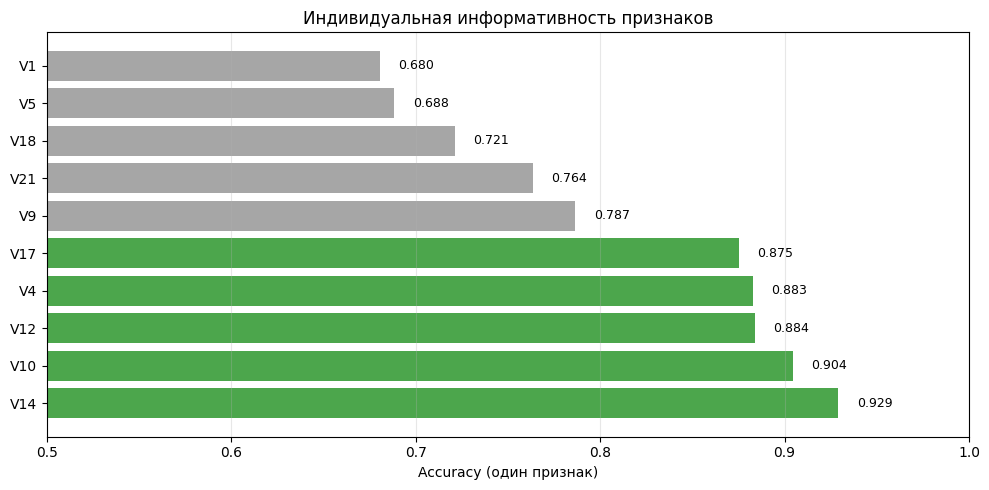


📊 Средняя accuracy по признакам: 0.812
   Важные признаки: 0.895
   Случайные признаки: 0.728
Вывод: Даже отдельные признаки хорошо разделяют классы


In [5]:
# Ячейка 6: Анализ индивидуальной информативности признаков
print("\n## Анализ: Индивидуальная информативность признаков")
print("=" * 60)

# Быстрый анализ - один признак
from sklearn.linear_model import LogisticRegression

single_feature_results = []
feature_names = X.columns.tolist()

# Проверяем только 5 самых важных и 5 случайных признаков
important_features = ['V14', 'V4', 'V10', 'V12', 'V17']
random_features = np.random.choice([f for f in feature_names if f not in important_features], 5, replace=False)
test_features = list(important_features) + list(random_features)

for feature in test_features:
    idx = feature_names.index(feature)
    X_single = X_train_scaled[:5000, idx].reshape(-1, 1)
    y_single = y_train[:5000].values if hasattr(y_train, 'values') else y_train[:5000]
    
    model = LogisticRegression(random_state=42)
    scores = cross_val_score(model, X_single, y_single, cv=3, scoring='accuracy')
    
    single_feature_results.append({
        'feature': feature,
        'accuracy': scores.mean(),
        'type': 'important' if feature in important_features else 'random'
    })

# Визуализация
single_df = pd.DataFrame(single_feature_results).sort_values('accuracy', ascending=False)

plt.figure(figsize=(10, 5))
colors = ['green' if t == 'important' else 'gray' for t in single_df['type']]
bars = plt.barh(range(len(single_df)), single_df['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Accuracy (один признак)')
plt.title('Индивидуальная информативность признаков')
plt.yticks(range(len(single_df)), single_df['feature'])
plt.xlim(0.5, 1.0)
plt.grid(True, alpha=0.3, axis='x')

# Добавляем значения
for bar, acc in zip(bars, single_df['accuracy']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 Средняя accuracy по признакам: {single_df['accuracy'].mean():.3f}")
print(f"   Важные признаки: {single_df[single_df['type']=='important']['accuracy'].mean():.3f}")
print(f"   Случайные признаки: {single_df[single_df['type']=='random']['accuracy'].mean():.3f}")
print("Вывод: Даже отдельные признаки хорошо разделяют классы")


## Анализ: Перекрытие распределений классов


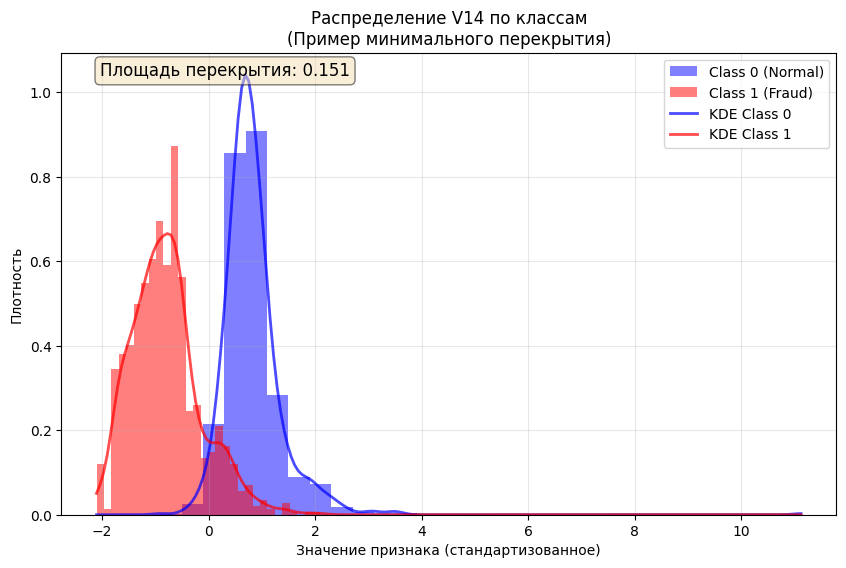

📊 Площадь перекрытия распределений: 0.151
   Интерпретация: 15.1% значений в зоне неопределённости
Вывод: Минимальное перекрытие → тривиальная классификация


In [6]:
# Ячейка 7: Визуализация перекрытия распределений 
print("\n## Анализ: Перекрытие распределений классов")
print("=" * 60)

# Берём самый информативный признак
best_feature = single_df.iloc[0]['feature']
best_idx = feature_names.index(best_feature)

# Данные для визуализации
sample_idx = np.random.choice(len(X_train_scaled), 2000, replace=False)
feature_values = X_train_scaled[sample_idx, best_idx]
class_labels = y_train.iloc[sample_idx] if hasattr(y_train, 'iloc') else y_train[sample_idx]

# График
plt.figure(figsize=(10, 6))

# Гистограммы
plt.hist(feature_values[class_labels == 0], bins=30, alpha=0.5, 
         label='Class 0 (Normal)', density=True, color='blue')
plt.hist(feature_values[class_labels == 1], bins=30, alpha=0.5,
         label='Class 1 (Fraud)', density=True, color='red')

# KDE
kde0 = gaussian_kde(feature_values[class_labels == 0])
kde1 = gaussian_kde(feature_values[class_labels == 1])

xs = np.linspace(feature_values.min(), feature_values.max(), 200)
plt.plot(xs, kde0(xs), 'b-', linewidth=2, alpha=0.7, label='KDE Class 0')
plt.plot(xs, kde1(xs), 'r-', linewidth=2, alpha=0.7, label='KDE Class 1')

plt.title(f'Распределение {best_feature} по классам\n(Пример минимального перекрытия)')
plt.xlabel('Значение признака (стандартизованное)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

# Вычисляем площадь перекрытия
overlap = np.minimum(kde0(xs), kde1(xs)).sum() * (xs[1] - xs[0])
plt.text(0.05, 0.95, f'Площадь перекрытия: {overlap:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

print(f"📊 Площадь перекрытия распределений: {overlap:.3f}")
print(f"   Интерпретация: {overlap:.1%} значений в зоне неопределённости")
print("Вывод: Минимальное перекрытие → тривиальная классификация")